# Torres Strait Coral Reef Stress Analysis

This notebook analyzes Great Barrier Reef stress information from NOAA's Coral Reef Watch program for the Torres Strait region.

Data source: https://coralreefwatch.noaa.gov/product/vs/data/torres_strait.txt

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import requests
from io import StringIO
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 10

## Data Loading and Processing

In [17]:
# Load data from NOAA
url = 'https://coralreefwatch.noaa.gov/product/vs/data/torres_strait.txt'
response = requests.get(url)
data_text = response.text

# Parse the data - find the header line and data
lines = data_text.strip().split('\n')

# Find the header line that starts with "YYYY MM DD"
header_line_idx = None
for i, line in enumerate(lines):
    if line.strip().startswith('YYYY MM DD'):
        header_line_idx = i
        break

if header_line_idx is None:
    print("Could not find header line starting with 'YYYY MM DD'")
else:
    print(f"Found header line at index {header_line_idx}: {lines[header_line_idx]}")
    
    # Parse data starting from the line after the header
    data_lines = []
    for i in range(header_line_idx + 1, len(lines)):
        line = lines[i].strip()
        if line:  # Skip empty lines
            parts = line.split()
            if len(parts) >= 10:  # Ensure we have all expected columns
                try:
                    # Validate first three parts are valid date components
                    year = int(parts[0])
                    month = int(parts[1])
                    day = int(parts[2])
                    if 1980 <= year <= 2030 and 1 <= month <= 12 and 1 <= day <= 31:
                        data_lines.append(parts[:10])  # Take only first 10 columns
                except (ValueError, IndexError):
                    continue
    
    print(f"Parsed {len(data_lines)} valid data rows")
    
    if len(data_lines) > 0:
        print(f"First data row: {data_lines[0]}")
        print(f"Last data row: {data_lines[-1]}")
        
        # Define columns based on the header
        columns = ['YYYY', 'MM', 'DD', 'SST_MIN', 'SST_MAX', 'SST_90th_HS', 
                   'SSTA_90th_HS', 'HS_gt_0', 'DHW_from_90th_HS', 'BAA_7day_max']
        
        # Create DataFrame
        df = pd.DataFrame(data_lines, columns=columns)
        print(f"DataFrame shape: {df.shape}")
        
        # Rename columns to lowercase for easier datetime parsing
        df.rename(columns={
            'YYYY': 'year',
            'MM': 'month',
            'DD': 'day'
        }, inplace=True)
        
        # Convert to appropriate data types
        for col in df.columns:
            df[col] = pd.to_numeric(df[col])
        
        # Create datetime column
        df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
        
        print(f"\nData loaded successfully!")
        print(f"Records: {len(df)}")
        print(f"Date range: {df['date'].min()} to {df['date'].max()}")
        print(f"\nFirst 5 rows:")
        print(df.head())
        
    else:
        print("ERROR: No valid data rows found!")
        print("Let's examine what we're getting...")
        
        # Debug: show first few non-empty lines after header
        for i in range(header_line_idx + 1, min(header_line_idx + 10, len(lines))):
            if i < len(lines) and lines[i].strip():
                parts = lines[i].split()
                print(f"Line {i}: {len(parts)} parts - {parts}")
                if len(parts) >= 3:
                    try:
                        year, month, day = int(parts[0]), int(parts[1]), int(parts[2])
                        print(f"  -> Date would be: {year}-{month:02d}-{day:02d}")
                    except ValueError as e:
                        print(f"  -> Can't parse as date: {e}")
        
        # Create empty DataFrame so rest of notebook doesn't fail
        columns = ['year', 'month', 'day', 'SST_MIN', 'SST_MAX', 'SST_90th_HS', 
                   'SSTA_90th_HS', 'HS_gt_0', 'DHW_from_90th_HS', 'BAA_7day_max']
        df = pd.DataFrame(columns=columns + ['date'])
        print("Created empty DataFrame to prevent errors in subsequent cells.")

Found header line at index 21: YYYY MM DD SST_MIN SST_MAX SST@90th_HS SSTA@90th_HS 90th_HS>0 DHW_from_90th_HS>1 BAA_7day_max
Parsed 14868 valid data rows
First data row: ['1985', '01', '01', '28.4200', '29.2900', '29.1000', '0.6171', '0.4500', '0.0000', '0']
Last data row: ['2025', '09', '17', '26.1600', '27.2500', '26.8900', '1.6613', '0.0000', '0.0000', '0']
DataFrame shape: (14868, 10)

Data loaded successfully!
Records: 14868
Date range: 1985-01-01 00:00:00 to 2025-09-17 00:00:00

First 5 rows:
   year  month  day  SST_MIN  SST_MAX  SST_90th_HS  SSTA_90th_HS  HS_gt_0  \
0  1985      1    1    28.42    29.29        29.10        0.6171     0.45   
1  1985      1    2    28.48    29.39        28.95        0.6206     0.52   
2  1985      1    3    28.41    29.25        28.90        0.4968     0.40   
3  1985      1    4    28.33    29.16        28.77        0.3581     0.28   
4  1985      1    5    28.60    29.77        29.01        0.5803     0.49   

   DHW_from_90th_HS  BAA_7day_max

## Data Processing for Visualization

In [18]:
# Filter data for the whole time range instead of just recent years
recent_data = df.copy()  # Use all available data

# Calculate monthly statistics for smoothing
recent_data['year_month'] = recent_data['date'].dt.to_period('M')

# Build aggregation dict - we know all columns exist now
monthly_stats = recent_data.groupby('year_month').agg({
    'SST_90th_HS': 'mean',
    'SST_MIN': 'mean',
    'SST_MAX': 'mean',
    'DHW_from_90th_HS': 'max',
    'BAA_7day_max': 'max',
    'date': 'first'
}).reset_index()

# Calculate climatology (long-term monthly averages)
df['month_num'] = df['date'].dt.month
climatology = df.groupby('month_num')['SST_90th_HS'].mean().reset_index()
climatology.columns = ['month_num', 'climatology_sst']

# Add climatology to monthly stats
monthly_stats['month_num'] = monthly_stats['date'].dt.month
monthly_stats = monthly_stats.merge(climatology, on='month_num')

# Define stress levels based on DHW and temperature thresholds
# Only color Alert Level 2 and Bleaching Warning
def get_stress_level(dhw, sst_anomaly):
    if dhw >= 8:
        return 'Alert Level 2'
    elif sst_anomaly > 1:
        return 'Bleaching Warning'
    else:
        return 'No Stress'

recent_data['stress_level'] = recent_data.apply(
    lambda x: get_stress_level(x['DHW_from_90th_HS'], x['SSTA_90th_HS']), axis=1
)

print(f"Full dataset: {len(recent_data)} records")
print(f"Monthly aggregated: {len(monthly_stats)} records")
print(f"\nStress level distribution in full dataset:")
if len(recent_data) > 0:
    print(recent_data['stress_level'].value_counts())
else:
    print("No data available")

# Show available columns
print(f"\nAvailable columns: {list(df.columns)}")
print(f"\nData date range: {df['date'].min()} to {df['date'].max()}" if len(df) > 0 else "No data available")
if len(recent_data) > 0:
    print(f"Full data date range: {recent_data['date'].min()} to {recent_data['date'].max()}")
else:
    print("No data found")

Full dataset: 14868 records
Monthly aggregated: 489 records

Stress level distribution in full dataset:
stress_level
No Stress            10503
Bleaching Warning     3722
Alert Level 2          643
Name: count, dtype: int64

Available columns: ['year', 'month', 'day', 'SST_MIN', 'SST_MAX', 'SST_90th_HS', 'SSTA_90th_HS', 'HS_gt_0', 'DHW_from_90th_HS', 'BAA_7day_max', 'date', 'month_num']

Data date range: 1985-01-01 00:00:00 to 2025-09-17 00:00:00
Full data date range: 1985-01-01 00:00:00 to 2025-09-17 00:00:00


## Create NOAA-style Visualization

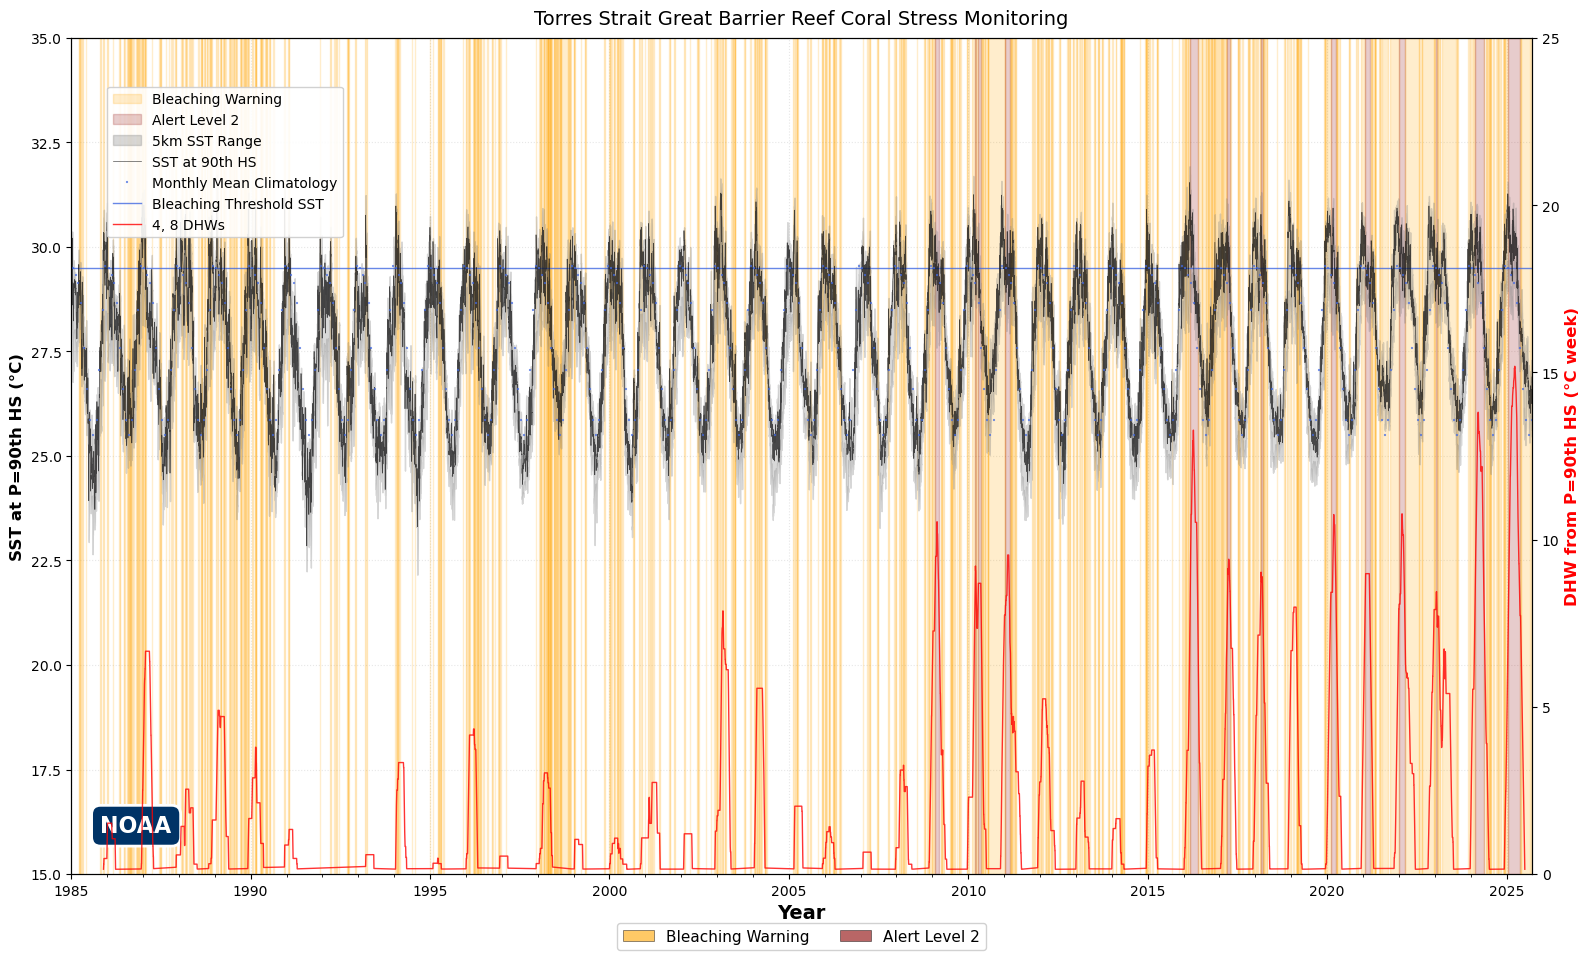

In [31]:
# Create the main plot
fig, ax1 = plt.subplots(figsize=(16, 10))

# Only create plot if we have data
if len(recent_data) > 0:
    # Define colors - only for Alert Level 2 and Bleaching Warning
    colors = {
        'No Stress': 'transparent',      # No color
        'Bleaching Warning': '#FFA500',  # Orange
        'Alert Level 2': '#8B0000'       # Dark red
    }

    # Plot background stress levels (only for Alert Level 2 and Bleaching Warning)
    stress_periods = []
    current_stress = None
    start_date = None

    for _, row in recent_data.iterrows():
        if row['stress_level'] != current_stress:
            if current_stress is not None and current_stress != 'No Stress':
                stress_periods.append((start_date, row['date'], current_stress))
            current_stress = row['stress_level']
            start_date = row['date']

    # Add final period if needed
    if current_stress is not None and current_stress != 'No Stress':
        stress_periods.append((start_date, recent_data['date'].max(), current_stress))

    # Plot stress level backgrounds (only significant events)
    legend_added = set()
    for start, end, stress in stress_periods:
        if stress in ['Alert Level 2', 'Bleaching Warning']:  # Only color these levels
            label = stress if stress not in legend_added else ""
            if label:
                legend_added.add(stress)
            ax1.axvspan(start, end, alpha=0.2, color=colors[stress], label=label, zorder=1)

    # Create second y-axis for DHW
    ax2 = ax1.twinx()

    # Plot SST range (min-max) as a gray band first (background)
    ax1.fill_between(recent_data['date'], recent_data['SST_MIN'], recent_data['SST_MAX'], 
                     color='gray', alpha=0.3, label='5km SST Range', zorder=2)

    # Plot main SST line (90th percentile)
    ax1.plot(recent_data['date'], recent_data['SST_90th_HS'], 
             color="#0B0B0C", linewidth=0.5, label='SST at 90th HS', alpha=0.7, zorder=4)

    # Plot monthly climatology across the full time range
    clim_dates = []
    clim_values = []
    start_year = recent_data['year'].min()
    end_year = recent_data['year'].max()
    
    for year in range(start_year, end_year + 1):
        for month in range(1, 13):
            try:
                date = datetime(year, month, 15)  # Use 15th of each month
                if recent_data['date'].min() <= date <= recent_data['date'].max():
                    clim_dates.append(date)
                    clim_value = climatology[climatology['month_num'] == month]['climatology_sst']
                    if not clim_value.empty:
                        clim_values.append(clim_value.iloc[0])
                    else:
                        clim_dates.pop()  # Remove the date if no climatology data
            except:
                pass

    if clim_dates and clim_values:
        ax1.plot(clim_dates, clim_values, '+', color='#4169E1', markersize=1, 
                 markeredgewidth=1.5, label='Monthly Mean Climatology', zorder=5, alpha=0.7)

    # Plot DHW on right axis with improved styling
    dhw_mask = recent_data['DHW_from_90th_HS'] > 0
    if dhw_mask.any():
        ax2.plot(recent_data[dhw_mask]['date'], recent_data[dhw_mask]['DHW_from_90th_HS'], 
                 'o-', color='#FF0000', linewidth=1, markersize=0, 
                 label='4, 8 DHWs', alpha=0.8, zorder=6)

    # Add reference lines
    bleaching_temp = 29.5  # Approximate bleaching threshold for Torres Strait
    ax1.axhline(y=bleaching_temp, color='#4169E1', linestyle='-', linewidth=1, 
                label='Bleaching Threshold SST', alpha=0.8, zorder=3)

    # Enhanced formatting
    ax1.set_xlabel('Year', fontsize=14, fontweight='bold')
    ax1.set_ylabel('SST at P=90th HS (°C)', fontsize=12, fontweight='bold', color='black')
    ax2.set_ylabel('DHW from P=90th HS (°C week)', fontsize=12, fontweight='bold', color='red')

    # Set y-axis limits to match NOAA chart exactly
    ax1.set_ylim(15, 35)
    ax2.set_ylim(0, 25)

    # Enhanced x-axis formatting for full time range
    ax1.xaxis.set_major_locator(mdates.YearLocator(5))  # Every 5 years
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax1.xaxis.set_minor_locator(mdates.YearLocator())

    # Set x-axis limits to show full data range
    ax1.set_xlim(recent_data['date'].min(), recent_data['date'].max())

    # Add professional grid
    ax1.grid(True, alpha=0.3, linestyle=':', linewidth=0.8, zorder=0)
    ax1.set_axisbelow(True)

    # Enhanced title
    # plt.suptitle('Torres Strait Great Barrier Reef Coral Stress Monitoring', fontsize=18, fontweight='bold', y=0.95)
    ax1.set_title('Torres Strait Great Barrier Reef Coral Stress Monitoring', fontsize=14, pad=10)

    # Create comprehensive legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()

    # Main data legend (upper left)
    if lines1 or lines2:
        legend1 = ax1.legend(lines1 + lines2, labels1 + labels2, 
                            loc='upper left', bbox_to_anchor=(0.02, 0.95), 
                            fontsize=10, framealpha=0.9)

    # Stress level legend (bottom) - only for colored levels
    stress_legend_elements = []
    if 'Bleaching Warning' in legend_added:
        stress_legend_elements.append(
            plt.Rectangle((0,0), 1, 1, facecolor=colors['Bleaching Warning'], alpha=0.6, 
                         edgecolor='black', linewidth=0.5, label='Bleaching Warning')
        )
    if 'Alert Level 2' in legend_added:
        stress_legend_elements.append(
            plt.Rectangle((0,0), 1, 1, facecolor=colors['Alert Level 2'], alpha=0.6, 
                         edgecolor='black', linewidth=0.5, label='Alert Level 2')
        )

    if stress_legend_elements:
        legend2 = ax1.legend(handles=stress_legend_elements, 
                            loc='lower center', bbox_to_anchor=(0.5, -0.1), 
                            ncol=len(stress_legend_elements), fontsize=11, frameon=True, framealpha=0.9)
        ax1.add_artist(legend1)

    # Add NOAA branding
    ax1.text(0.02, 0.05, 'NOAA', transform=ax1.transAxes, 
             fontsize=16, fontweight='bold', 
             bbox=dict(boxstyle='round,pad=0.4', facecolor='#003366', edgecolor='white', linewidth=2),
             color='white', zorder=10)

    plt.tight_layout()
    if stress_legend_elements:
        plt.subplots_adjust(bottom=0.12)  # Make room for stress level legend if present

else:
    # No data available - show message
    ax1.text(0.5, 0.5, 'No data available\\nPlease check data loading cell above', 
             transform=ax1.transAxes, ha='center', va='center', fontsize=16, 
             bbox=dict(boxstyle='round,pad=1', facecolor='lightgray', alpha=0.8))
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    ax1.set_title('Torres Strait Coral Stress Monitoring - No Data Available', fontsize=14)

plt.show()

## Summary Statistics

In [20]:
# Display summary statistics
print("Torres Strait SST Analysis Summary")
print("=" * 40)

if len(recent_data) > 0:
    print(f"Data period: {recent_data['date'].min().strftime('%Y-%m-%d')} to {recent_data['date'].max().strftime('%Y-%m-%d')}")
    print(f"\nSST Statistics (°C):")
    print(f"  Mean SST: {recent_data['SST_90th_HS'].mean():.2f}")
    print(f"  Min SST: {recent_data['SST_90th_HS'].min():.2f}")
    print(f"  Max SST: {recent_data['SST_90th_HS'].max():.2f}")
    print(f"\nStress Level Distribution:")
    stress_counts = recent_data['stress_level'].value_counts()
    for level, count in stress_counts.items():
        percentage = (count / len(recent_data)) * 100
        print(f"  {level}: {count} days ({percentage:.1f}%)")

    print(f"\nDegree Heating Weeks (DHW) Statistics:")
    print(f"  Maximum DHW recorded: {recent_data['DHW_from_90th_HS'].max():.1f} °C-weeks")
    print(f"  Days with DHW > 4: {(recent_data['DHW_from_90th_HS'] >= 4).sum()}")
    print(f"  Days with DHW > 8: {(recent_data['DHW_from_90th_HS'] >= 8).sum()}")
        
    print(f"\nTemperature Anomaly Statistics:")
    print(f"  Mean SSTA: {recent_data['SSTA_90th_HS'].mean():.2f}°C")
    print(f"  Max SSTA: {recent_data['SSTA_90th_HS'].max():.2f}°C")
    print(f"  Days with SSTA > 1°C: {(recent_data['SSTA_90th_HS'] > 1).sum()}")
else:
    print("No recent data (2024-2025) available for analysis")

if len(df) > 0:
    print(f"\nOverall dataset:")
    print(f"  Total records: {len(df)}")
    print(f"  Date range: {df['date'].min().strftime('%Y-%m-%d')} to {df['date'].max().strftime('%Y-%m-%d')}")
    print(f"  Years of data: {df['date'].max().year - df['date'].min().year + 1}")
    
    # Show recent years available
    recent_years = sorted(df['year'].unique())[-10:]  # Last 10 years
    print(f"  Recent years in dataset: {recent_years}")
else:
    print("\nNo data loaded - please check the data loading cell above")

Torres Strait SST Analysis Summary
Data period: 1985-01-01 to 2025-09-17

SST Statistics (°C):
  Mean SST: 27.75
  Min SST: 22.85
  Max SST: 31.54

Stress Level Distribution:
  No Stress: 10503 days (70.6%)
  Bleaching Warning: 3722 days (25.0%)
  Alert Level 2: 643 days (4.3%)

Degree Heating Weeks (DHW) Statistics:
  Maximum DHW recorded: 15.2 °C-weeks
  Days with DHW > 4: 1953
  Days with DHW > 8: 643

Temperature Anomaly Statistics:
  Mean SSTA: 0.62°C
  Max SSTA: 3.18°C
  Days with SSTA > 1°C: 4213

Overall dataset:
  Total records: 14868
  Date range: 1985-01-01 to 2025-09-17
  Years of data: 41
  Recent years in dataset: [np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]
